# ASHRAE 데이터 필사

원본: https://www.kaggle.com/nroman/eda-for-ashrae

필사 공부


## 사전 탐색
필사에 앞서, 혼자서 데이터 개요를 훑어보겠다.

- Overview
 - 건물의 에너지(냉수, 전기, 온수, 증기) 소모에 관한 데이터이다.
 - 온 세상에서 추출한 1000개 이상의 건물의 3년치 데이터.
 
- Data
 - 에너지 효율이 얼마나 개선되었는지는 측정하기가 힘든 지표다. 그래서 counterfactual model(다른 가정을 해보는 것)을 구축하는 방식을 쓰곤 한다. 즉, 새로운 에너지 소비 모델을 만들었다면 이전 소비 모델을 계속 유지했을 때를 가정해서 둘의 효율을 비교하는 것이다.
 - 본 대회는 네가지 에너지 타입에 대해서 이런 counterfactural model을 잘 구축할 수 있는지가 관건이다.
 - 파일에 포함된 것:
  - train.csv: 빌딩 ID, 계측값(전기, 냉수, 증기, 온수 - 모든 빌딩이 이 4가지 계측값을 갖추고 있지는 않다), 계측 시간, 에너지 소모(주로 kWh 단위, 계측값 중에는 잘못 측정된 것이 있을 수 있다는 것을 염두에 둘 것)
  - building_meta.csv: site_id(날씨 파일에 접근하기 위한 키 값), building_id(training.csv에 접근하기 위한 키 값), primary_use(잘 모르겠다), square_feet(건물의 바닥 면적), year_built(건물의 연식?), floor_count(건물의 층수)
  - weather_\[train/test\].csv: site_id, air_temperature(섭씨 온도), cloud_coverage(하늘이 구름으로 가려진 정도), dew_temperature(섭씨 온도), precip_depth_1_hr(precipication- 강수, 밀리미터 단위), sea_level_pressure(대기입? Millibar/hectopascals 단위), wind_direction(0~360도까지), wind_speed(m/sec 단위)
  - test.csv: 행 번호를 ID로 삼고 있다. 데이터가 딱히 없고, 나의 예측을 순서대로 넣기 위해 존재하는 파일이다. row_id, building_id, meter, timestamp
  - sample_submission.csv: 주의 사항이 몇가지 있는데 잘 모르겠음





In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


### Introduction

In this competition we are to create model to predict an energy usage per building and per meter.

We are given a dataset of around 1450 buildings containing such information as building id, which is a unique identifier of a building across both train and test dataset. Meter - is the type of meter that measures the data-enrgy consumption in kWh. Different buildings might have different meters installed. Some of them have only one type of meter, some have all four.

So we need to make a predictions for each meter of each building

---
이 대회에서 우리는 빌딩별, 계측 값 별 에너지 소모량을 에측하는 모델을 만들어야 합니다.

우리에게는 1450개의 건물의 데이터(건물 ID, 계측값)가 주어졌습니다. 서로 다른 건물에는 다른 계측 장치가 달렸을 것입니다. 어떤 건물은 한 가지 계측값만 있을 것이고, 어떤 건물은 4가지 계측값 모두가 있을 것입니다.

따라서 우리는 각 건물에 대한 계측값에 대한 예측을 만들어야 합니다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns # 데이터 분포 시각화 라이브러리
import warnings # 파이썬 경고 메시지 제어
import gc # Garbage Collector, 파이썬 메모리 관리 라이브러리
warnings.simplefilter('ignore') # 경고를 인쇄하지 않도록 하는 설정
matplotlib.rcParams['figure.dpi'] = 100 # 차트의 기본 크기 설정(dots per inch)
sns.set() # seaborn의 환경 변수 설정
%matplotlib inline

### Loading data

In [3]:
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

### Merging everything into two datasets: train and test

In [4]:
train = train.merge(building, on='building_id', how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')
# merge는 pandas 라이브러리에서 주어짐.

train = train.merge(weather_train, on = ['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')
del weather_train, weather_test, building
gc.collect(); # 메모리 수거

In [5]:
# Saving some memory
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id':np.int8,
          'primary_use':'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

# 딱 필요한 데이터의 길이 만큼만 할당을 해주도록 변경하는 과정인 것 같음.
# default 값은 float64인 듯?

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])

train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(train["timestamp"])


gc.collect()
# 줄인 메모리만큼 회수하기

0

### Amount of data and NaNs.

데이터의 수를 파악해보자.

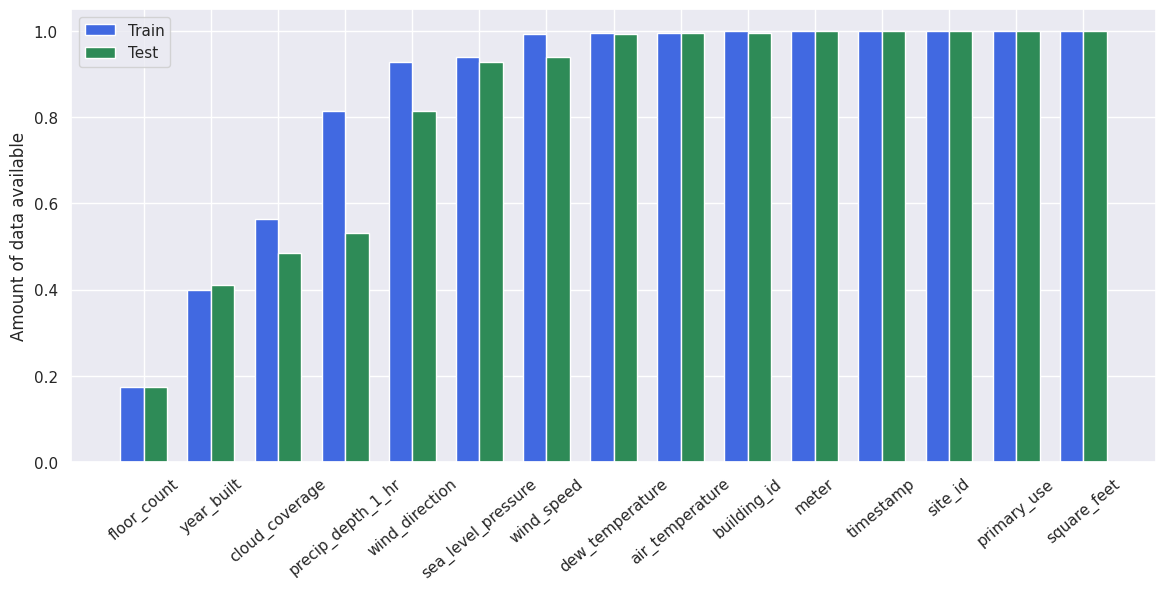

In [7]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
# 윗줄은 어떤 걸 하는 건지 잘 모르겠다..
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi = 100)
tr = axes.bar(ind, train_data, width, color = 'royalblue')

test_data = ((test.count())/len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color = 'seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation = 40)
# rotation은 그냥 텍스트 회전 용이다.
axes.legend([tr, tt], ['Train', 'Test']);

### Mean meter reading by day

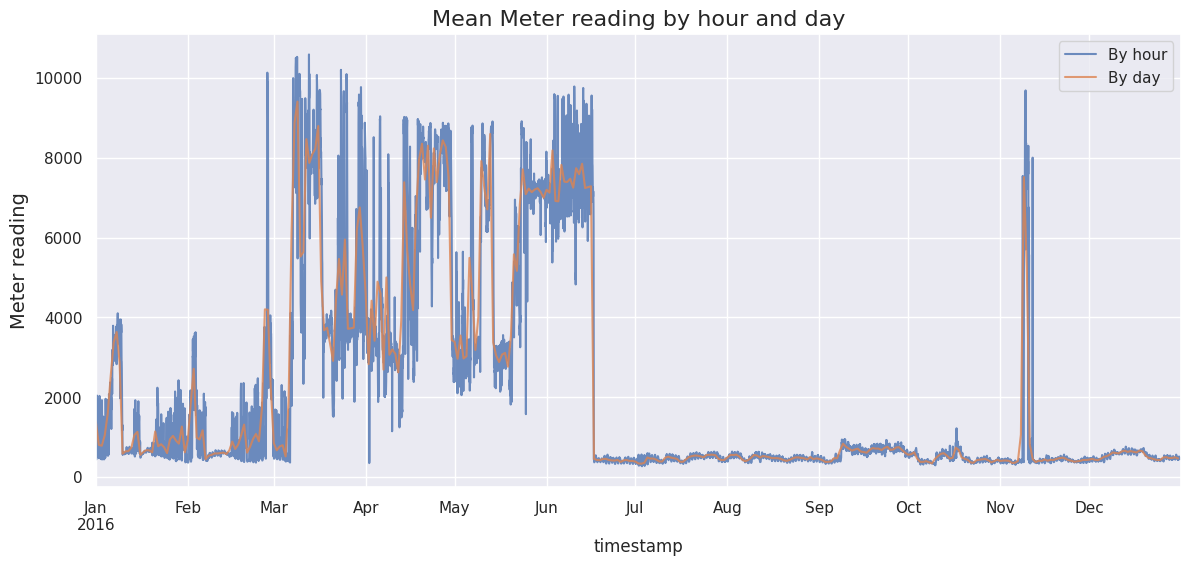

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi = 100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha = 0.8).set_ylabel('Meter reading', fontsize = 14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha = 0.8).set_ylabel('Meter reading', fontsize = 14);

# resample은 Pandas 라이브러리에 있는 함수. 시계열(timeseries) 데이터에 대해 샘플링 레이트를 다르게 한다.
# "1H" 는 1시간 단위로 샘플, "1D"는 1일 단위 샘플

axes.set_title('Mean Meter reading by hour and day', fontsize = 16);
axes.legend();

Doesn't this look weird? First reading are at the average level from January to March, then they explode from March to June and then drop down to almost zero with some peak at November.

Let's take a closer look.

---
다소 이상한 모양이지 않나요? 초반 1\~3월까지는 평이하다가 3\~6월 사이에는 폭증한 이후 거의 0까지 뚝 떨어진 후엔 11월의 몇몇 피크 값을 제외하곤 계속 유지합니다.

좀더 자세히 살펴 보도록 합시다.

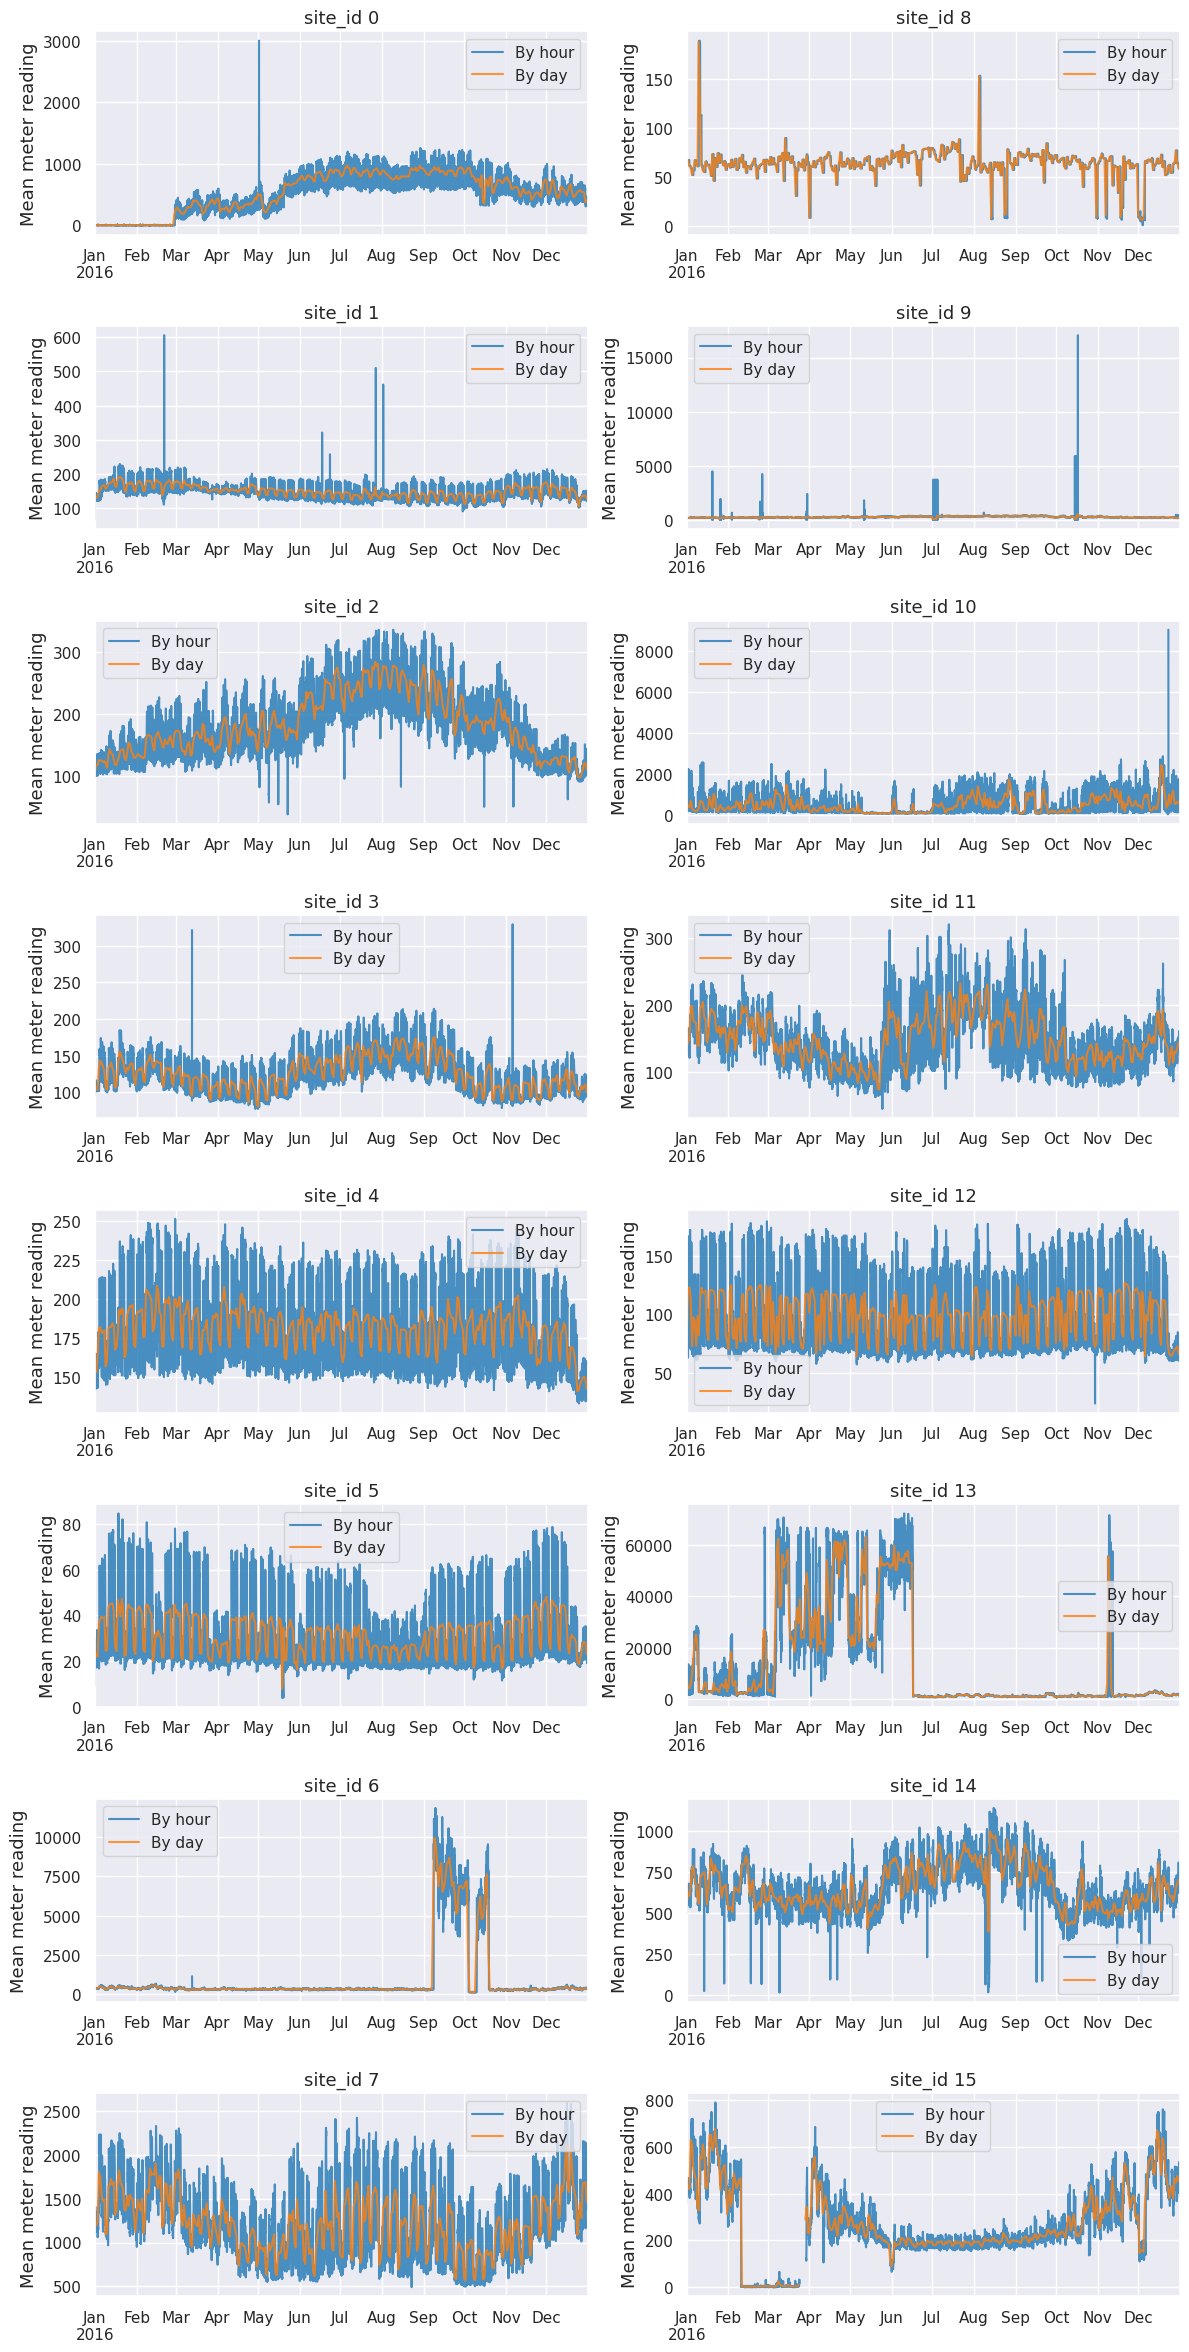

In [9]:
fig, axes = plt.subplots(8, 2, figsize= (14, 30), dpi = 100)
for i in range(train['site_id'].nunique()):
    # nunique는 Pandas 라이브러리 소속 함수로, 고유 값의 개수를 나타냅니다.
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color = 'tab:blue').set_ylabel('Mean meter reading', fontsize = 13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By day', color = 'tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize = 13);
    plt.subplots_adjust(hspace = 0.45)
    # 이쪽은 뭘 한 건지 잘 이해가 안 간다...

So what do we see here?
- First of all, as it was already discussed, **site_id 0** starts from March. Untill that time all measurements are 0's. Maybe buildings in that area were under construction? As a conclusion - we don't need all the data for this particular site_id before that date.
- **site_id 13** looks a lot like the overall mean meter_reading, isn't it? Lets take even a closer look.

---
자, 무엇을 볼 수 있나요?
- 우선, 이미 논의된 바와 같이, site_id 0은 3월부터 시작합니다. 그 이전까지의 모든 계측값은 모두 0 입니다. 그 기간에 공사라도 했던 걸까요? 결론적으로 - 이 site_id의 경우엔 저 시점 이전의 모든 데이터가 필요 없습니다.
- site_id 13은 모든 site의 계측 값 그래프와 비슷하게 생긴 것 같지 않나요? 좀더 자세히 들여다 봅시다.

### Mean meter reading by primary_use for site_id==13

IndexError: index 0 is out of bounds for axis 0 with size 0

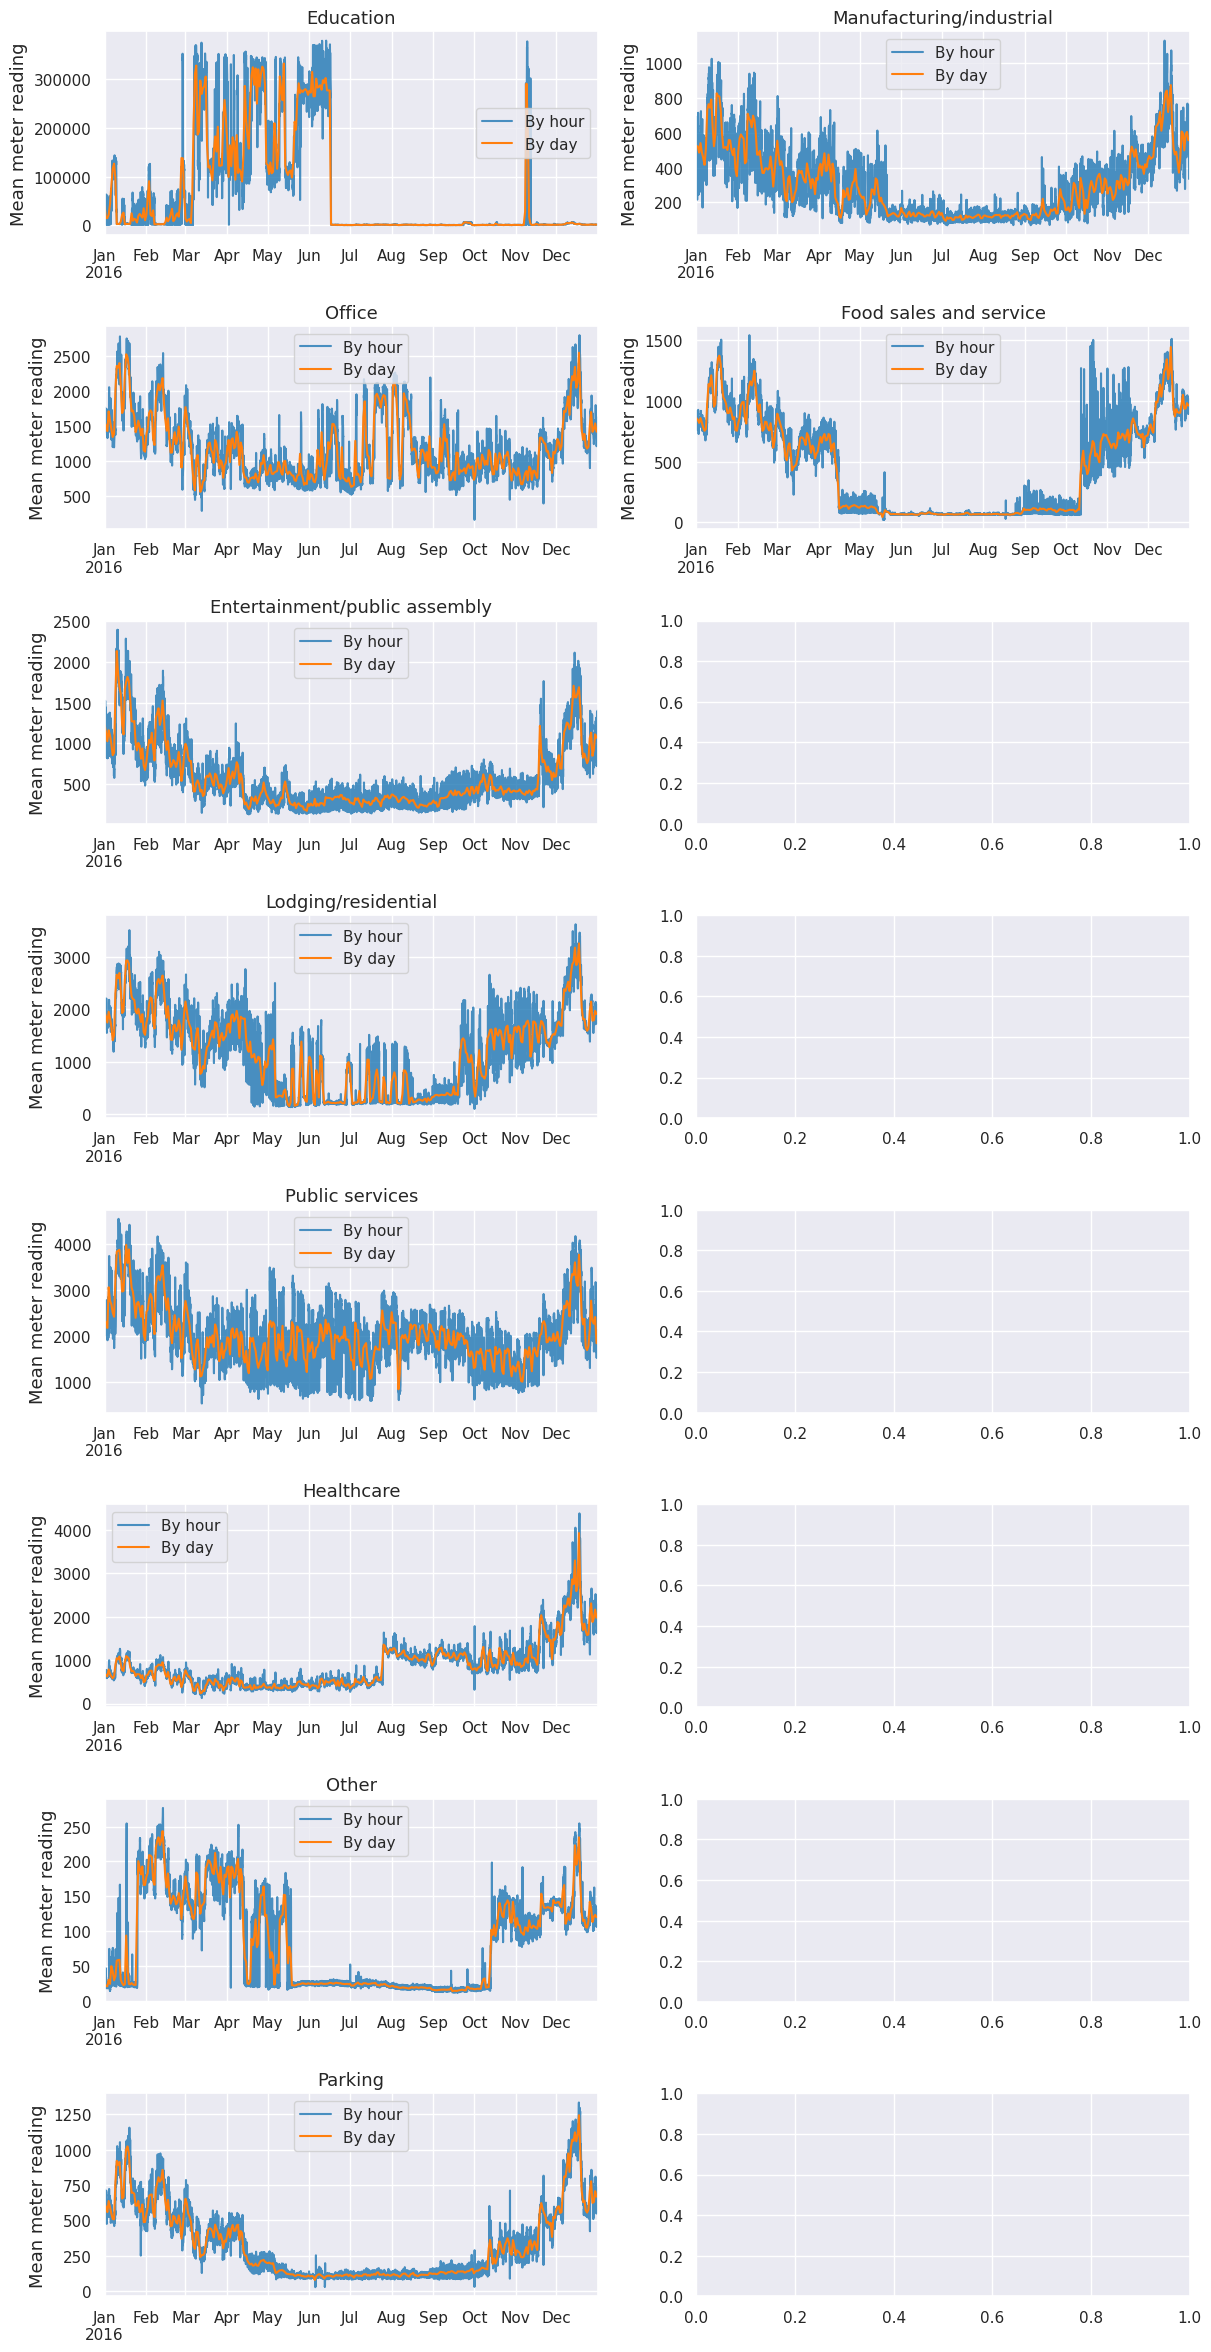

In [10]:
fig, axes = plt.subplots(8, 2, figsize=(14, 30), dpi = 100)
for i, use in enumerate(train['primary_use'].value_counts().index.to_list()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax = axes[i%8][i//8], alpha = 0.8, label = 'By hour', color= 'tab:blue').set_ylabel('Mean meter reading', fontsize = 13);
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax = axes[i%8][i//8], alpha = 1, label = 'By day', color= 'tab:orange').set_xlabel('');
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize = 13);
    plt.subplots_adjust(hspace = 0.45)

요건.. 원본 코드를 복사해도 똑같은 에러가 뜨네요

One more level of conclusions:
- site_id == 13 and primary_use = Education looks a lot like a general mean for meter reading. So it is really invest a lost into the whole data
- site_id == 13 and primary_use == Technology/Science also have 0's in meter readings in January. Just like site_id 0, that we found earlier.

Let's keep digging and see what meter type is responsible for such weird look of the meter reading for site_id 13 and primary_use Education

---

한 단계 더 나아가자면 :
- site_id ==13 이고 primary_use == Education 인 데이터는 계측 값 전체의 평균과 굉장히 비슷하게 생겼습니다. 따라서 이건 전체 데이터에 손실을 안겨 줍니다 (?)
- site_id == 13 이고 primary_use == Technology/Science인 데이터 역시 1월에 0인 데이터를 갖고 있습니다. 앞서 발견했던 site_id 0인 데이터와 마찬가지로 말입니다.

계측값의 괴상한 모양을 만드는 데 어떤 데이터들의 책임이 있는지 알아내기 위해, site_id 13 이며 primary_use == Education인 데이터를 더 파보도록 하겠습니다.

### Mean meter reading by meter type for primary_use == Education and site_id == 13

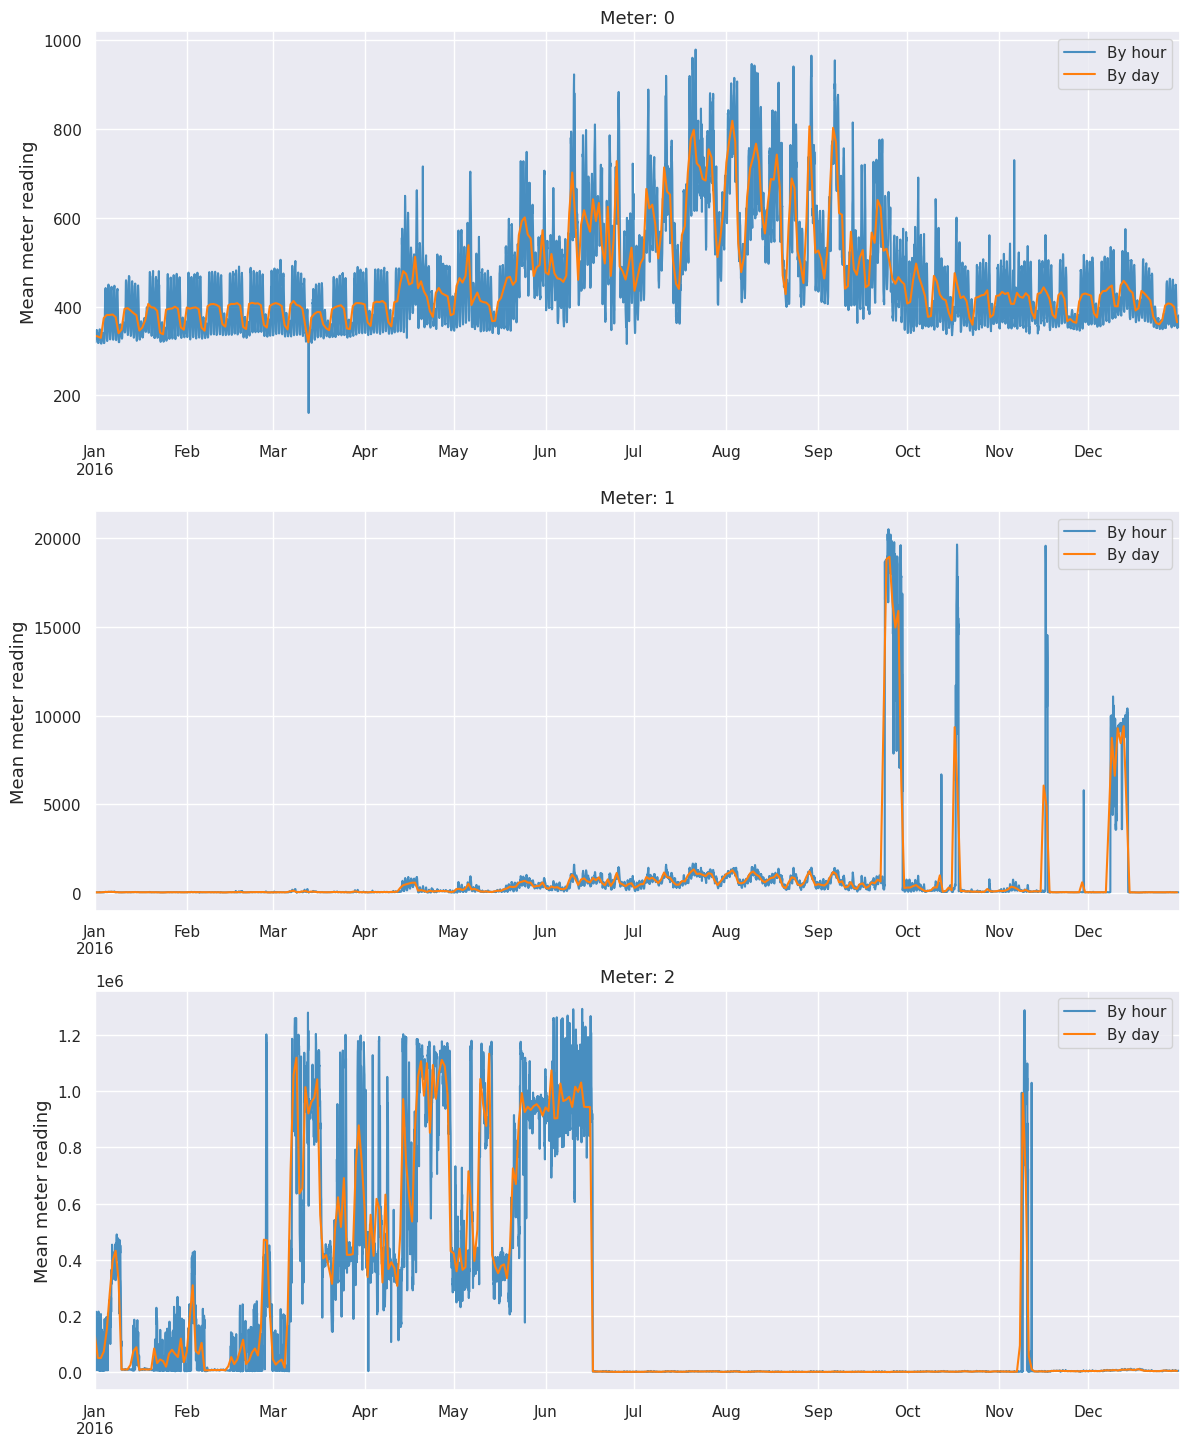

In [11]:
fig, axes = plt.subplots(3, 1, figsize = (14, 18), dpi = 100)
for i in train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')]['meter'].value_counts(dropna = False).index.to_list():
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax = axes[i], alpha = 0.8, label='By hour', color = 'tab:blue').set_ylabel('Mean meter reading', fontsize = 13)
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax = axes[i], alpha = 1, label='By day', color = 'tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    

Fine. What we have right now is that site_id 13 with primary_use Education and meter type 2 is responsible for this mess.

But we need to go deeper. There are 17 buildings that fall under these criteria. No problem. Another plot.

---
좋아요, 이제 우리는 site_id 13이며 primary_use가 Education인 데이터 중 meter type 2가 이 사태의 원인인 것을 알아냈습니다.

하지만 여기서 더 깊게 들어가야 합니다. 아직 17개의 건물 중에 범인이 있기 때문입니다. 이걸 찾아내는 건 큰 일이 아닙니다. 다른 plot을 또 그리면 되죠.

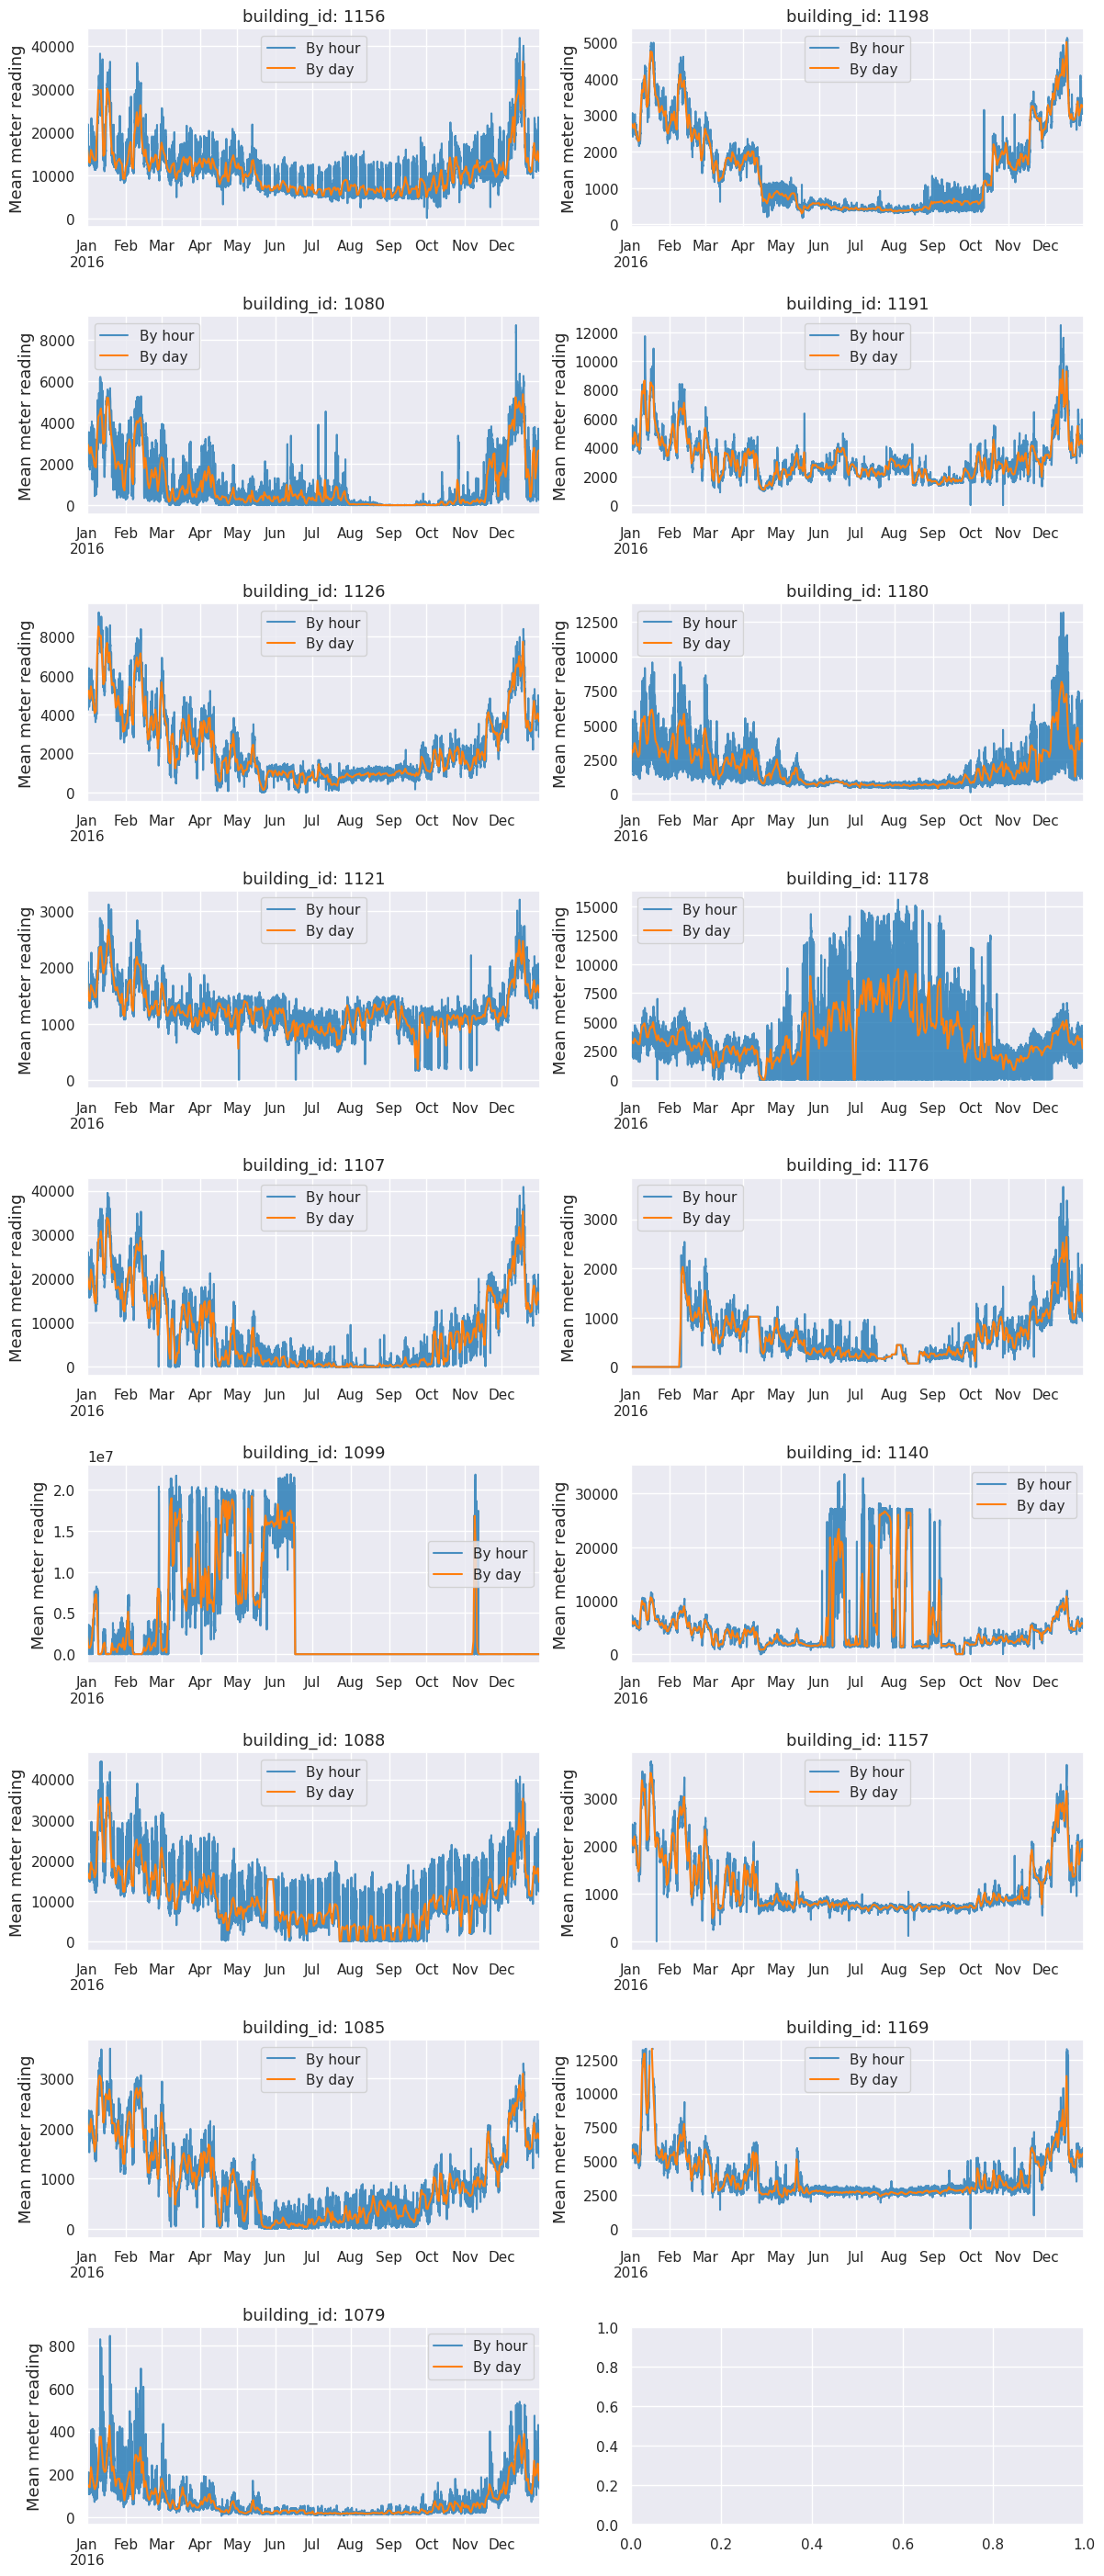

In [12]:
fig, axes = plt.subplots(9, 2, figsize=(14, 36), dpi =100)
for i, building in enumerate(train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter']==2)]['building_id'].value_counts(dropna = False).index.to_list()):
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax = axes[i%9][i//9], alpha = 0.8, label = 'By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax = axes[i%9][i//9], alpha = 1, label = 'By day', color='tab:orange').set_xlabel('');
    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building),fontsize = 13);
    plt.subplots_adjust(hspace = 0.45) # 서브 플롯 간격 조절

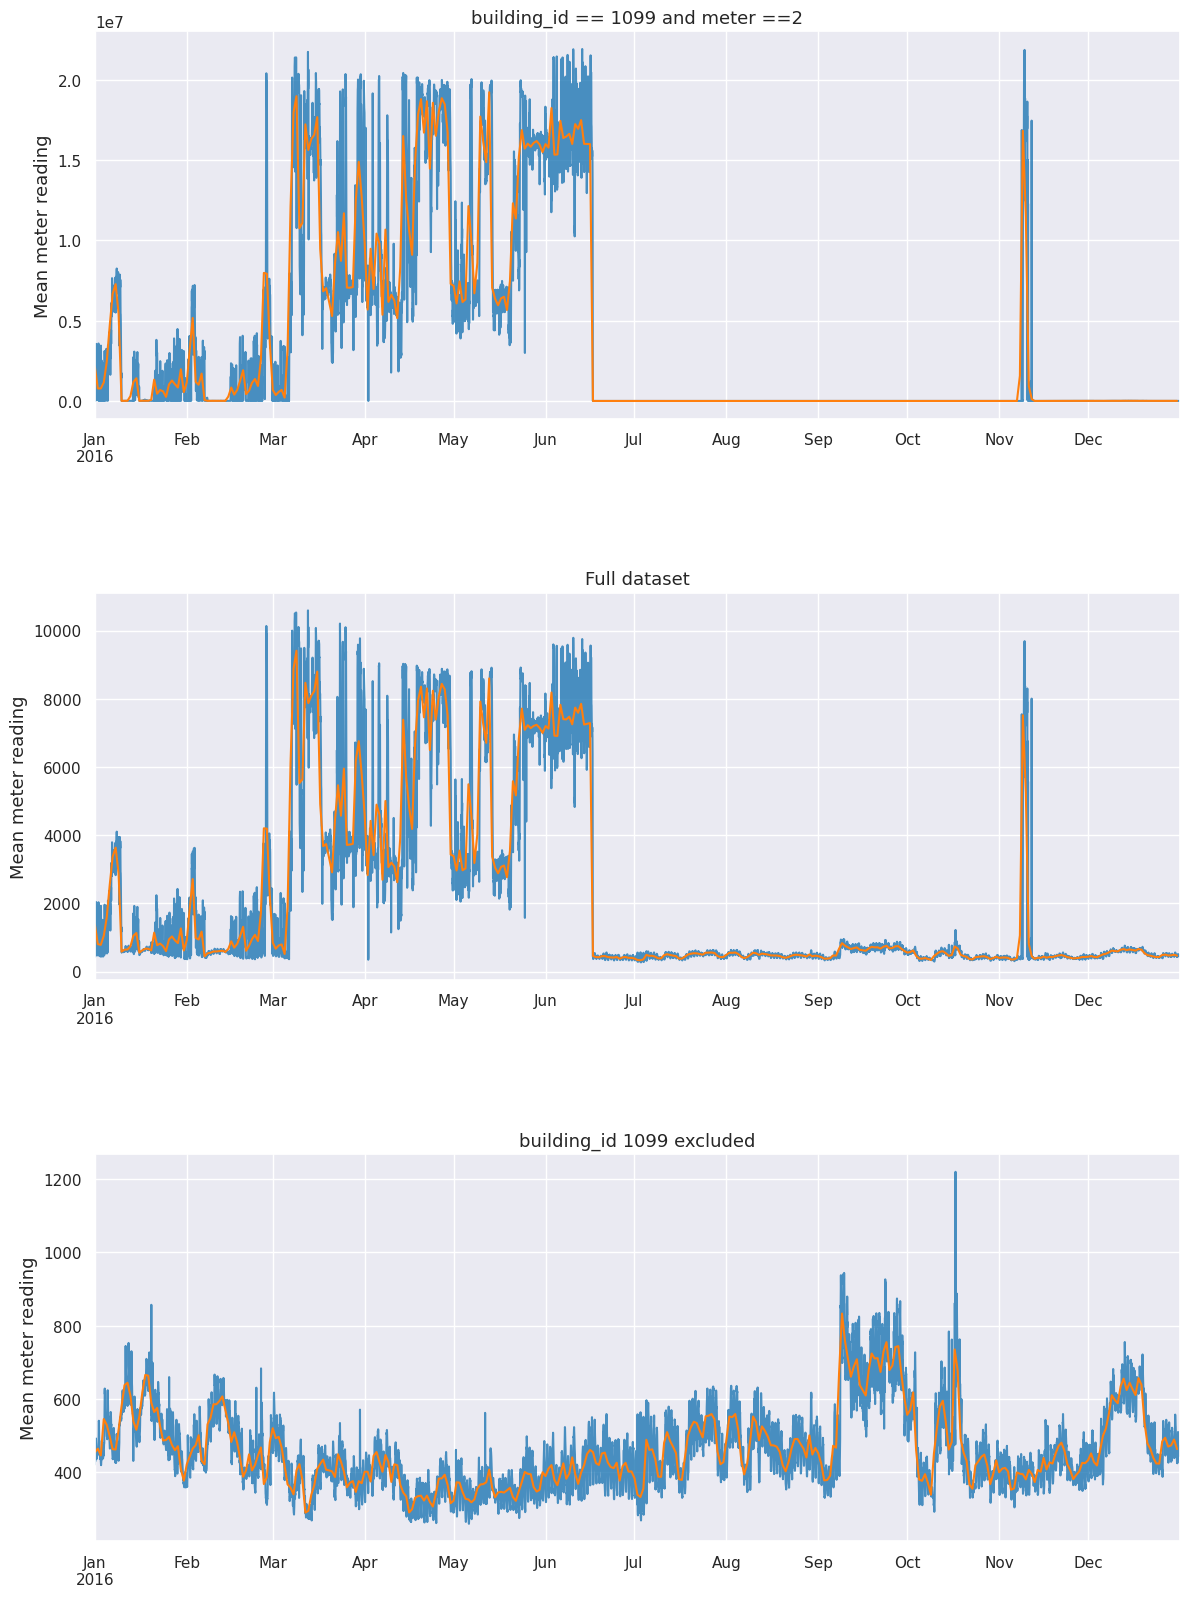

In [13]:
fig, axes = plt.subplots(3, 1, figsize = (14, 20), dpi = 100)

# 건물 1099 번의 2번 계측기의 plot
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax = axes[0], alpha = 0.8, label = 'By hour', color = 'tab:blue').set_ylabel('Mean meter reading', fontsize = 13);
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax = axes[0], alpha = 1, label = 'By day', color = 'tab:orange').set_xlabel('');
# 전체 계측값
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');
# 전체 계측값에서 건물 1099번의 2번 계측기의 값만 제외한 값
train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax = axes[2], alpha = 0.8, label = 'By hour', color = 'tab:blue').set_ylabel('Mean meter reading', fontsize = 13);
train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax = axes[2], alpha = 1, label = 'By day', color = 'tab:orange').set_xlabel('');

axes[0].set_title('building_id == 1099 and meter ==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize = 13);
axes[2].set_title('building_id 1099 excluded', fontsize = 13)
plt.subplots_adjust(hspace = 0.45)

## Number of observations by day
This is something interesting. We can see that number of observations by day in testing dataset is always same. But not in the training set.

---
흥미로운 사실은, test 데이터에서의 하루 당 관찰 횟수가 항상 동일하지만 training 데이터에선 그렇지않다는 점입니다.

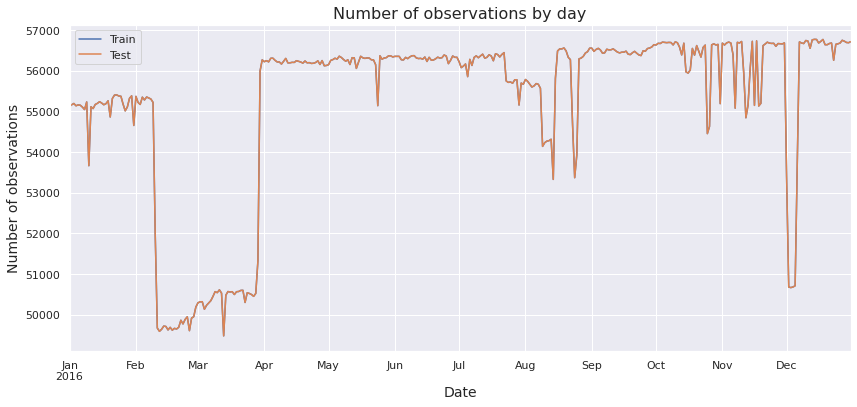

In [14]:
fig, axes = plt.subplots(1, 1, figsize = (14, 6))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax = axes).set_xlabel('Date', fontsize = 14);
test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax = axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

# 이쪽 코드는 코드를 복붙해서 실행시켜도 결과가 다르네요

## Meter
meter - The meter id code. Read as (0: electricity, 1: chilledwater, 2: steam, 3:hotwater). Not every building has all meter type.

Looks like steam is the most unefficient way of heating things up.

---

계측값의 ID 코드는 이렇게 읽으면 됩니다.
- 0: 전기
- 1: 냉수
- 2: 증기
- 3: 온수
모든 건물이 모든 계측값을 갖고 있는 것은 아닙니다.

보아하니 증기 설비가 난방에 가장 비효율적인 방식인 것 같군요.

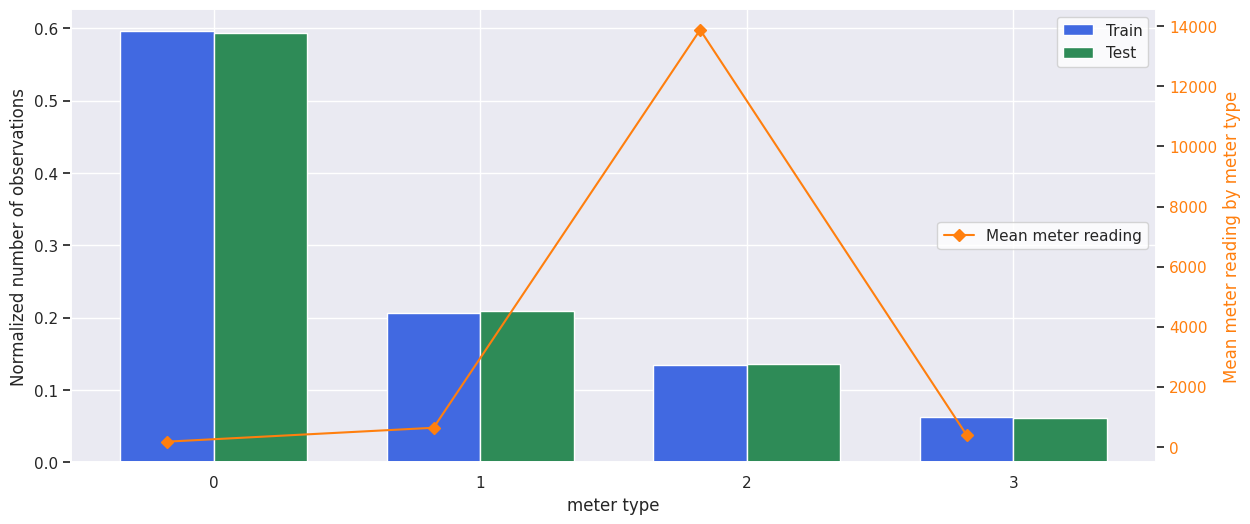

In [15]:
train_data = train['meter'].value_counts(dropna = False, normalize= True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1, 1, figsize = (14, 6), dpi = 100)
tr = axes.bar(ind, train_data, width, color = 'royalblue')

test_data = test['meter'].value_counts(dropna = False, normalize = True).sort_index().values
tt = axes.bar(ind + width, test_data, width, color = 'seagreen')

axes.set_ylabel('Normalized number of observations')
axes.set_xlabel('meter type')
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation = 0)

axes2 = axes.twinx() # x축을 공유하고 y축은 따로 갖는 복사본
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label = 'Mean meter reading');
axes2.grid(False)
axes2.tick_params(axis = 'y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color = 'tab:orange');

axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor = 'white');


# 여기서 사용되는 value_counts는 pandas 라이브러리에서 나옴
# dropna = True가 디폴트이며, 이걸 사용하면 NaN을 세지 않는다. 즉 이번 플롯에선 NaN값을 포함.

### Box plot for meter reading by meter type with outliers removed

---
계측 종류별 계측값 박스 플롯 (이상치 제거)

<AxesSubplot:xlabel='meter', ylabel='meter_reading'>

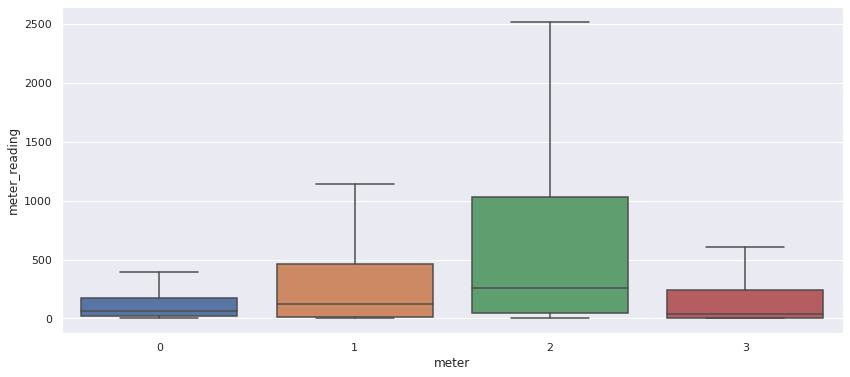

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x = 'meter', y = 'meter_reading', data=train, showfliers = False)
# showflier 이라는 인자로 outlier(이상치) 제외 여부를 전달하는 듯

### Box plot of air temperature by meter type

---
계측 종류별 대기 온도 박스 플롯

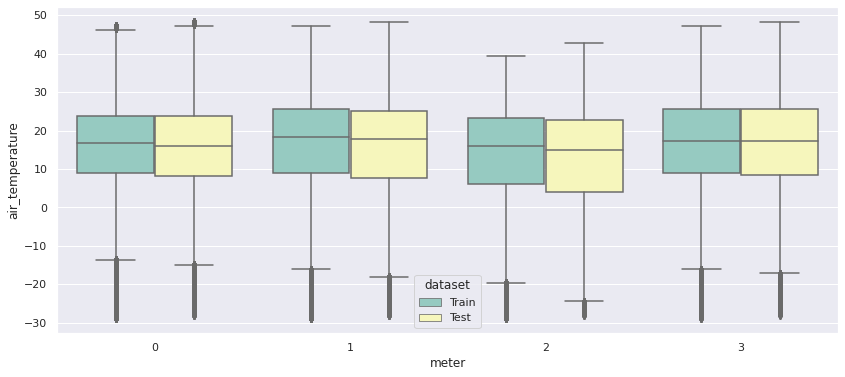

In [17]:
tmp_df = pd.concat([train[['meter', 'air_temperature']], test[['meter', 'air_temperature']]], ignore_index = True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'
# Training 데이터랑 Test 데이터 합치고, 인덱스 순서를 기준으로 태그 붙이기

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

## site_id
site_id - Foreign key for the weather files.
In my understanding this is a location.

---
site_id는 날씨 파일에 대한 지역 키 입니다.
제 생각에 이 건 장소를 뜻합니다.

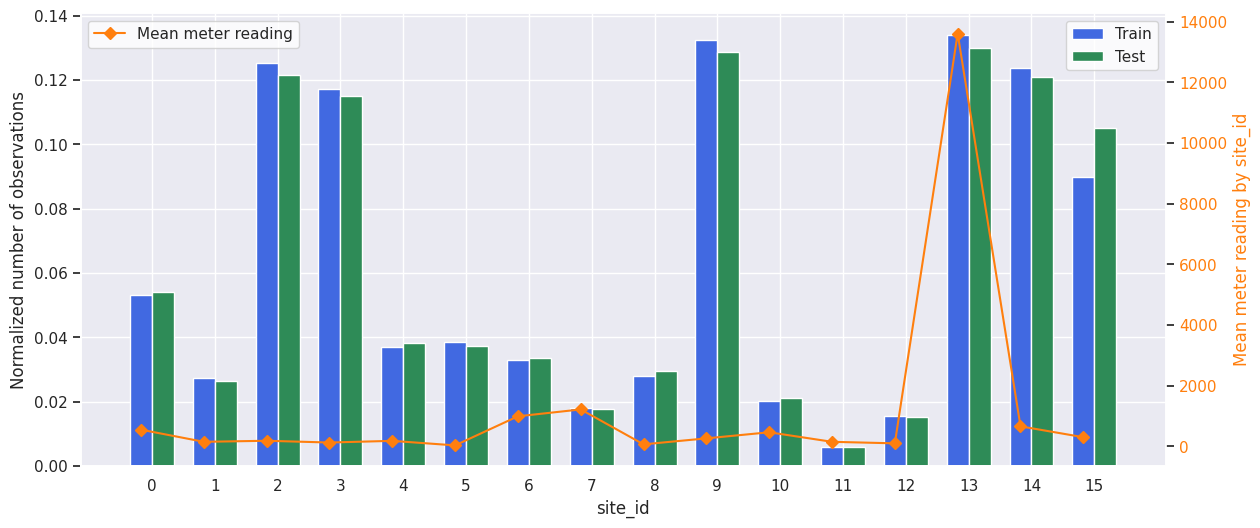

In [18]:
# bar plot

train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi = 100)
tr = axes.bar(ind, train_data, width, color='royalblue')
test_data = test['site_id'].value_counts(dropna=False, normalize = True).sort_index().values
tt = axes.bar(ind + width, test_data, width, color = 'seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation= 0)

axes2 = axes.twinx()
mr = axes2.plot(ind , train[['site_id','meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False)
axes2.tick_params(axis='y', labelcolor = 'tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color = 'tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc = 2, facecolor='white')

### Box plot of meter reading by site_id with outliers removed


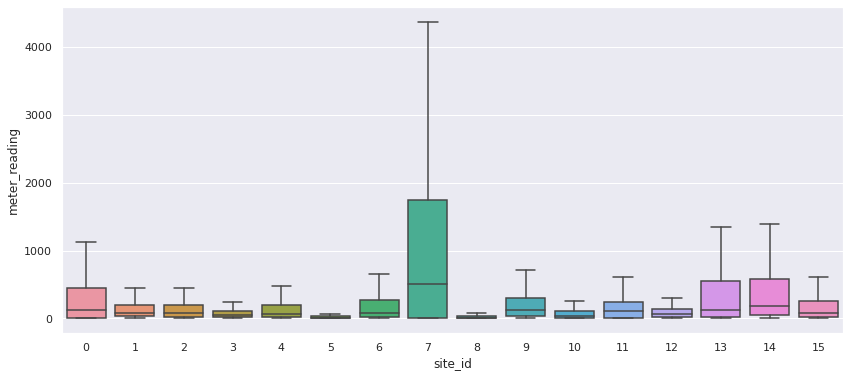

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x = 'site_id', y = 'meter_reading', data=train, showfliers=False);

### Box plot of air temperature by site_id

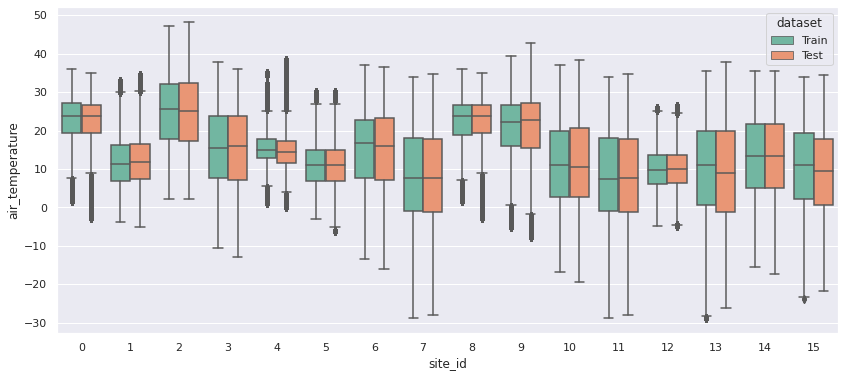

In [20]:
# dataframe으로 합치기
tmp_df = pd.concat([train[['site_id', 'air_temperature']], test[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index>len(train), 'dataset'] = 'Test'

# dataframe으로 만든 데이터를 seaborn 라이브러리에
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set2");

del tmp_df
gc.collect();

## primary_use
primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions

---

EnergyStar에서 만든 property type definitions에 따른 건물의 용도 카테고리입니다.

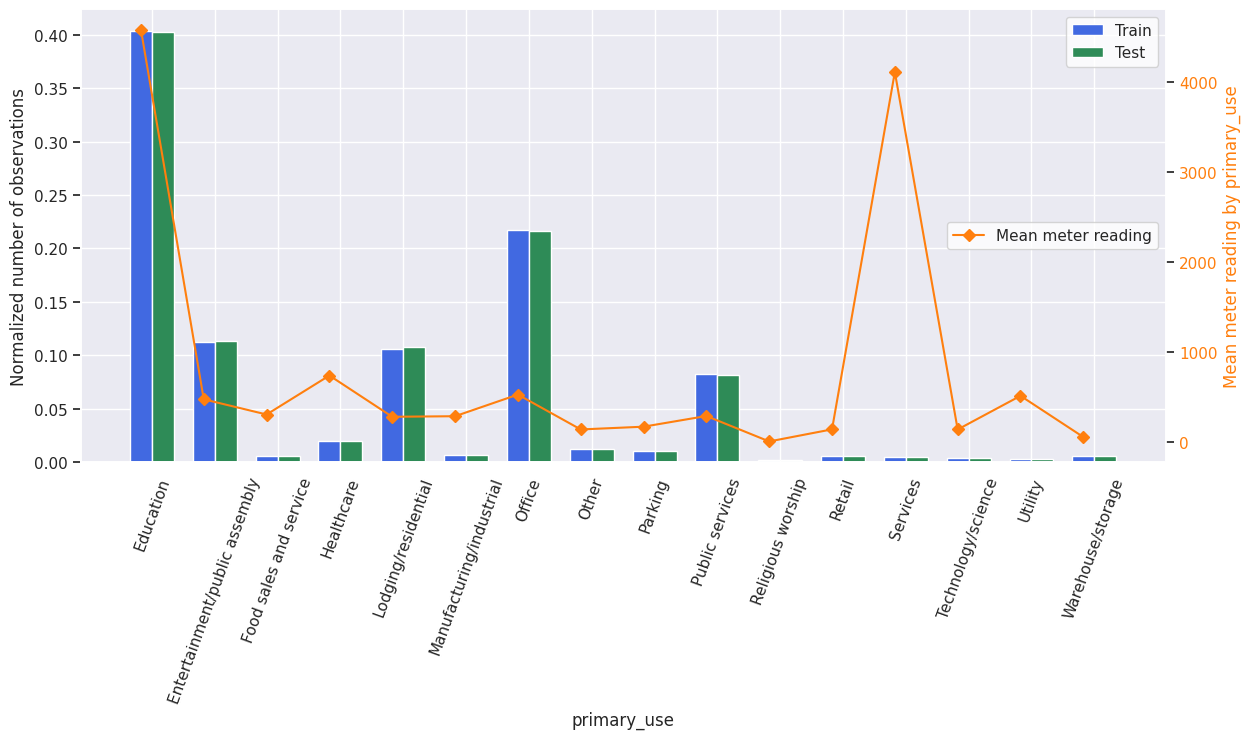

In [21]:
# site_id에서 썼던 식에서 조금의 수정만 했음

train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi = 100)
tr = axes.bar(ind, train_data, width, color='royalblue')
test_data = test['primary_use'].value_counts(dropna=False, normalize = True).sort_index().values
tt = axes.bar(ind + width, test_data, width, color = 'seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation= 70)

axes2 = axes.twinx()
mr = axes2.plot(ind , train[['primary_use','meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False)
axes2.tick_params(axis='y', labelcolor = 'tab:orange');
axes2.set_ylabel('Mean meter reading by primary_use', color = 'tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc = 5, facecolor='white')

## square_feet
square_feet - Gross floor area of the building


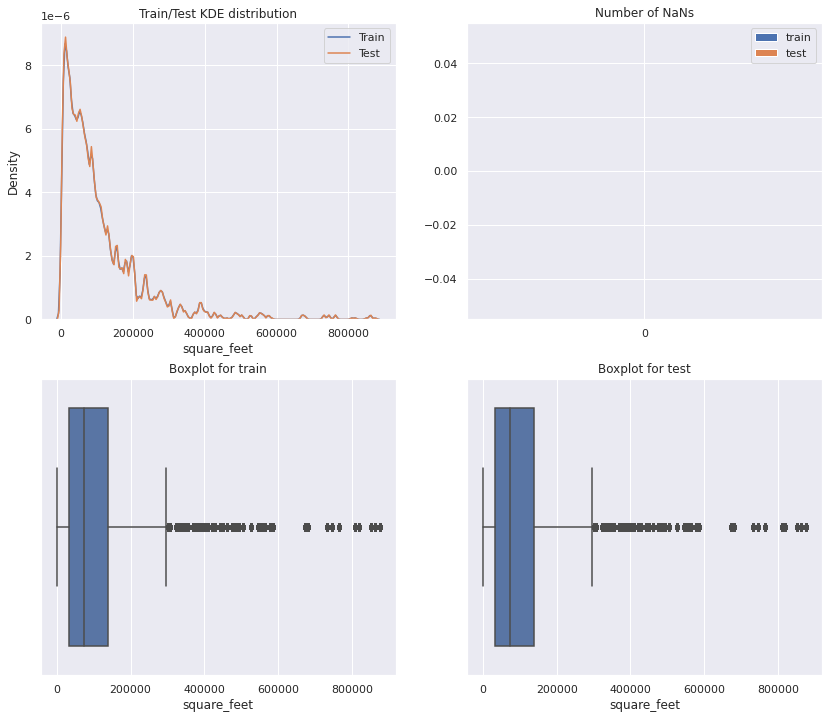

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (14, 12))
sns.kdeplot(train['square_feet'], ax = axes[0][0], label = 'Train');
sns.kdeplot(test['square_feet'], ax = axes[0][0], label= 'Test');
sns.boxplot(x = train['square_feet'], ax = axes[1][0]);
sns.boxplot(x = test['square_feet'], ax = axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()],
             'test': [test['square_feet'].isnull().sum()]}).plot(kind = 'bar', rot = 0, ax = axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

# KDE plot은 커널 밀도 추정 plot이라고 하는데,, 무슨 기능인지 모르겠어요


square_feet is 100% the same as building_id. I am going to show that.
Every building_id has only one unique value.
Which makes sence - building_id is a unique building identifier and each building can have only one possible value of square_feet. Also year_built is going to be the same per unique builing_id. Just keep that in mind.

---

바닥 면적은 building_id와 완벽히 똑같습니다. 이걸 지금 보여드리려 합니다.
모든 builing_id는 오직 하나의 고유한 값을 가집니다. 물론 건물을 구별해주는 인식표에 해당하기 때문에 당연한 얘기기도 합니다. 
또한 year_built도 building_id에 대해 똑같은 관계입니다(?)

In [7]:
print(train[train['building_id']==0]['square_feet'].value_counts())
print(train[train['building_id'] == 1]['square_feet'].value_counts())
print(train[train['building_id'] == 100]['square_feet'].value_counts())

7432    8784
Name: square_feet, dtype: int64
2720    8784
Name: square_feet, dtype: int64
24456    8784
Name: square_feet, dtype: int64


In [8]:
# sort_index라는 메서드였는데 아무리 인자를 바꿔도 안 먹혀서 바꿔봤어요

train[['building_id', 'square_feet']].sort_values(by = 'building_id')

building_id  square_feet
0                   0         7432
4232656             0         7432
11161913            0         7432
13433842            0         7432
15695236            0         7432
...               ...          ...
17664532         1448        92271
7917878          1448        92271
7920222          1448        92271
7908496          1448        92271
20216099         1448        92271

[20216100 rows x 2 columns]

Let's take a look at the mean meter reading by building_id

---

평균 계측값을 building_id에 대해서 확인해봅시다

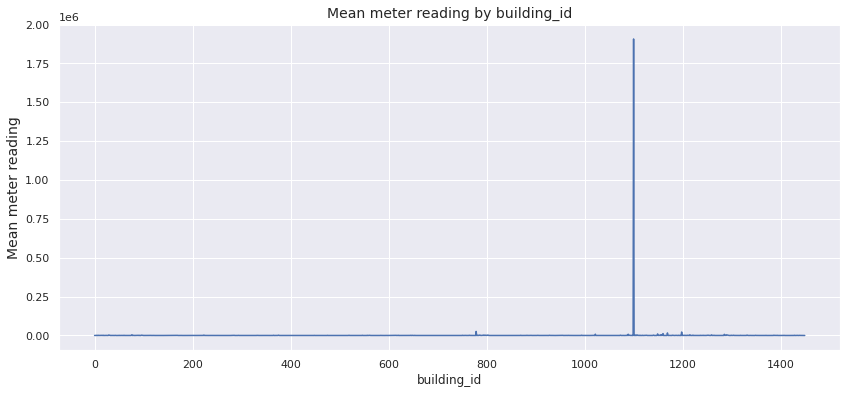

In [9]:
fig, axes = plt.subplots(1, 1, figsize = (14, 6))
train.groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize = 14);
axes.set_ylabel('Mean meter reading', fontsize = 14);

There is an obvious outlier in data. Let's see what it is.

Well, it is an educational building with no year_build or floor_count provided, so probably it is an old one.

They have a steam meter which measures such an outstanding amount of electricity used.

It seems to me that this is a really old school with a steam heating.

---

데이터 중에는 명백히 이상치가 섞여 있습니다. 어떤 것인지 한 번 봅시다.

year_build나 floor_count 정보가 없는 교육 목적 건물이네요. 분명 오래된 건물일 것입니다.

steam meter의 계측값이 이 건물이 에너지를 눈에 띄게 많이 사용한다는 것을 알려 주네요.

증기로 난방을 하는 아주 오래된 학교가 아닐까 생각합니다.

In [10]:
train[(train['building_id'] == 1099) & (train['meter_reading'] > 3000000)]

building_id  meter           timestamp  meter_reading  site_id  \
1534             1099      2 2016-01-01 00:00:00      3241630.0       13   
3830             1099      2 2016-01-01 01:00:00      3241630.0       13   
22191            1099      2 2016-01-01 09:00:00      3554740.0       13   
24488            1099      2 2016-01-01 10:00:00      3341210.0       13   
38275            1099      2 2016-01-01 16:00:00      3009500.0       13   
...               ...    ...                 ...            ...      ...   
17345482         1099      2 2016-11-10 15:00:00     15008300.0       13   
17347844         1099      2 2016-11-10 16:00:00      5399540.0       13   
17350207         1099      2 2016-11-10 17:00:00     10357700.0       13   
17352570         1099      2 2016-11-10 18:00:00     12274400.0       13   
17420378         1099      2 2016-11-11 23:00:00     17447600.0       13   

         primary_use  square_feet  year_built  floor_count  air_temperature  \
1534       Education       332884         NaN          NaN             -8.3   
3830       Education       332884         NaN          NaN             -8.3   
22191      Education       332884         NaN          NaN             -6.7   
24488      Education       332884         NaN          NaN             -8.3   
38275      Education       332884         NaN          NaN             -6.7   
...              ...          ...         ...          ...              ...   
17345482   Education       332884         NaN          NaN              9.4   
17347844   Education       332884         NaN          NaN             11.7   
17350207   Education       332884         NaN          NaN             13.9   
17352570   Education       332884         NaN          NaN             16.1   
17420378   Education       332884         NaN          NaN              7.8   

          cloud_coverage  dew_temperature  precip_depth_1_hr  \
1534                 8.0            -12.2                NaN   
3830                 NaN            -11.7               -1.0   
22191                NaN             -9.4               -1.0   
24488                NaN            -11.7                0.0   
38275                NaN            -10.6                0.0   
...                  ...              ...                ...   
17345482             0.0              2.8                0.0   
17347844             0.0              3.3                0.0   
17350207             0.0              3.3                0.0   
17352570             0.0              4.4                0.0   
17420378             0.0             -3.3                0.0   

          sea_level_pressure  wind_direction  wind_speed  
1534             1023.299988           250.0         4.1  
3830             1023.299988           240.0         4.1  
22191            1022.000000           250.0         3.6  
24488            1021.900024           270.0         6.7  
38275            1017.900024           230.0         6.2  
...                      ...             ...         ...  
17345482         1013.799988           230.0         4.6  
17347844         1013.500000           250.0         4.6  
17350207         1013.700012           270.0         5.1  
17352570         1013.299988           270.0         4.6  
17420378         1032.099976             0.0         0.0  

[2746 rows x 16 columns]

And there is one more interesting thing, that I want to check. This building is located at site_id 13. So maybe this is some old area? Or this building is the only one consuming so much in the neighbourhood?

So I have decided to plot mean energy consumption by site_id WITH and WITHOUT this particular building included. And this is what it looks like.

Pay attention - the 'Mean meter reading scale' has changed by a factor of 10. So this is the only building with such an enormoush mesurements.

---

한가지 더 확인해보고 싶은 것이 있습니다. 이 건물은 현재 site_id 13에 위치앴죠. 그렇다면 이 지역이 전체적으로 다 낡은 건물들만 있는 걸까요? 아니면 이 특정 건물만 에너지를 크게 소비하는 걸까요?

이 걸 확인해보기 위해 저는 이 지역의 에너지 소비량을 해당 건물을 포함한 plot과 포함하지 않은 plot을 그려 비교해보기로 했습니다. 아래에 그 결과가 있습니다.

'Mean meter reading scale'이 factor 10에 의해 변화했다는 사실에 주목해주세요. 이 지역에서 에너지를 무지막지하게 소비하는 건물은 딱 이 건물 뿐이라는 결론을 내릴 수 있습니다.


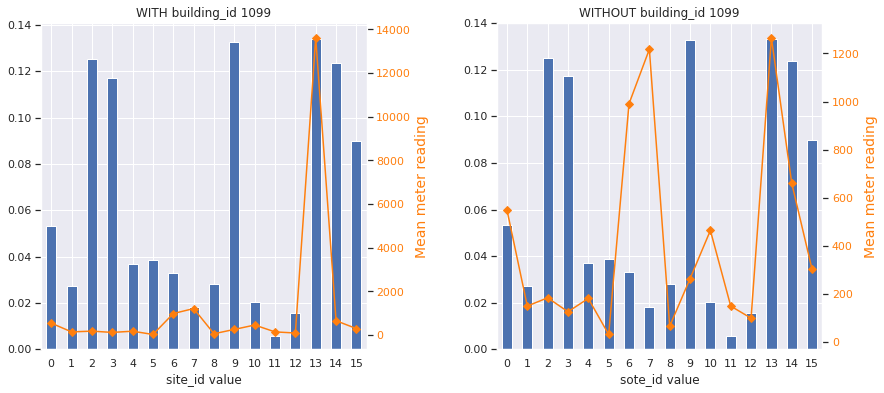

In [11]:
fig, axes = plt.subplots(1, 2, figsize= (14, 6))
train['site_id'].value_counts(dropna = False, normalize = True).sort_index().plot(kind = 'bar', rot = 0, ax = axes[0]).set_xlabel('site_id value')
train[train['building_id'] != 1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('sote_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange')
train[train['building_id'] != 1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange')
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14)
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax3.tick_params(axis='y', labelcolor='tab:orange')
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');


Mean meter reanding by building_id WITHOUT building_id 1099

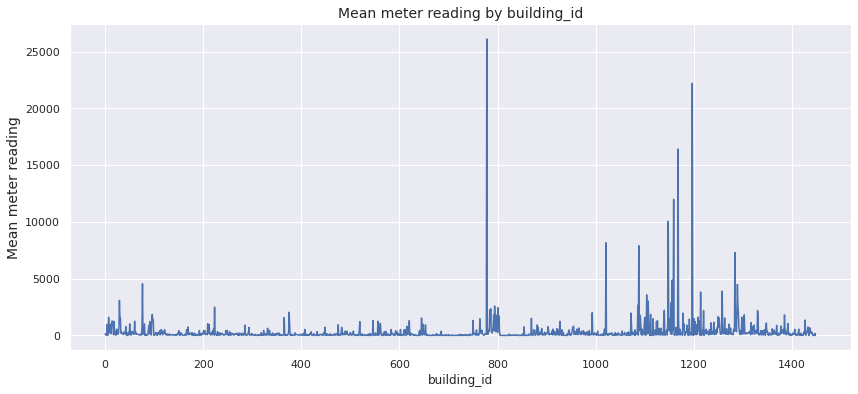

In [12]:
fig, axes = plt.subplots(1, 1 , figsize = (14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

## year_built
year_built - Year building was opened

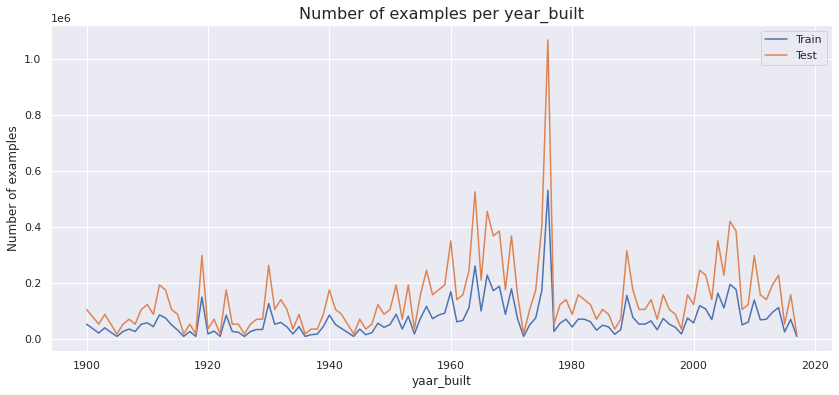

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train['year_built'].value_counts(dropna = False).sort_index().plot(ax = axes).set_xlabel('yaar_built');
test['year_built'].value_counts(dropna = False).sort_index().plot(ax = axes).set_ylabel('Number of examples');
axes.legend(['Train', 'Test']);
axes.set_title('Number of examples per year_built', fontsize = 16);


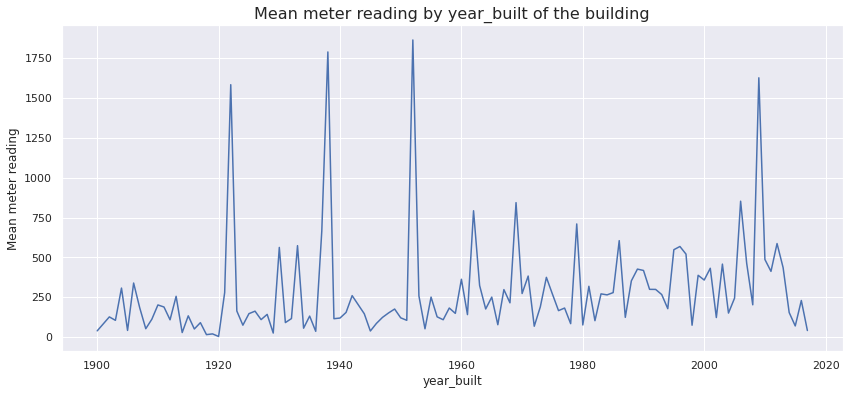

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize = 16);

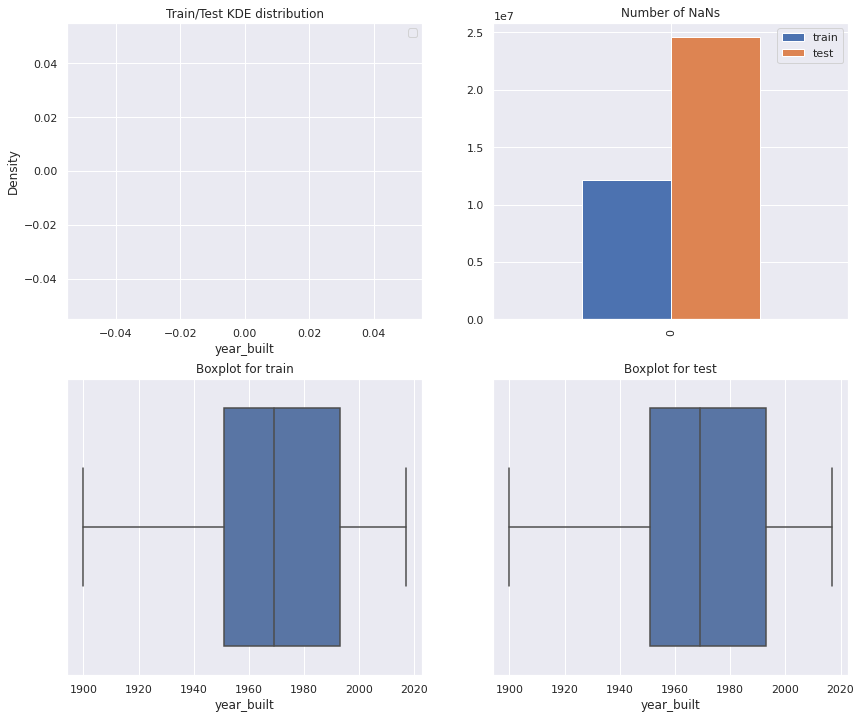

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.kdeplot(train['year_built'],ax=axes[0][0], label='Train');
sns.kdeplot(test['year_built'], ax=axes[0][0], label='Test');

sns.boxplot(x=train['year_built'], ax=axes[1][0]);
sns.boxplot(x=test['year_built'], ax=axes[1][1]);

pd.DataFrame({'train': [train['year_built'].isnull().sum()], 'test': [test['year_built'].isnull().sum()]}).plot(kind='bar', ax = axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');

gc.collect(); # 여기서 정리하는 메모리는 어떤 거지? DataFrame인가


## air_temperature
air_temperature - Degrees Celsius

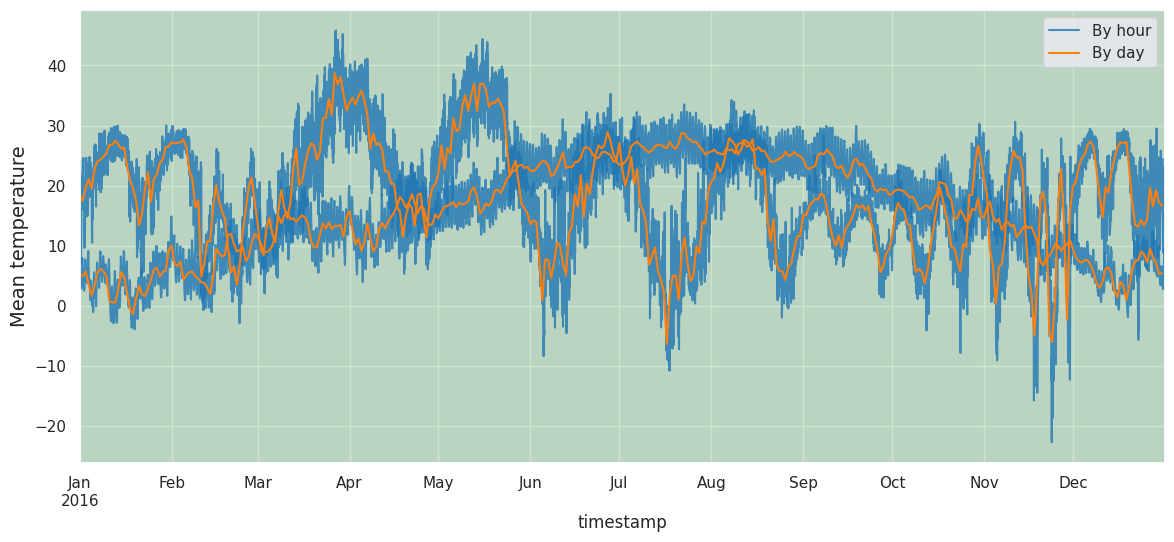

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi = 100)
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax = axes, alpha = 0.8, label = 'By hour', color = 'tab:blue').set_ylabel('Mean temperature', fontsize = 14);
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax = axes, alpha = 0.8, color = 'tab:blue', label = '')

train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax = axes, alpha = 1, label = 'By day', color = 'tab:orange')
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax = axes, alpha = 1, color = 'tab:orange', label = '');
axes.legend();

#  axes.text(train['timestamp'].iloc[9000000], -3, 'Train', fontsize=16);
# axes.text(test['timestamp'].iloc[29400000], 30, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor = 'green', alpha = 0.2)
# 이쪽 세줄은 아예 모르겠네요
# 그대로 따라 치면 버전 문제인지 오류가 뜨고, 몇가지 삭제해도 원래 의도했던 그림이 안 나오네요

Air temperature by site_id. Looks like some sites are more to north and some more to south